<a href="https://colab.research.google.com/github/soroushmirzaei/engineering-industries-projects/blob/main/iranian-automobiles-classification/iranian-automobiles-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirements libraries
import os
import shutil
import zipfile

#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [ ]:
#make kaggle json file
kaggle_json = {
    "username":"kaggle-api-token-username",
    "key":"kaggle-api-token-key"
}
pd.Series(kaggle_json).to_json('kaggle.json')

#install kaggle libraries
!pip install -q kaggle

#setup kaggle libraries
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
#download kaggle dataset
!kaggle datasets download usefashrfi/iran-used-cars-dataset


 97% 148M/152M [00:00<00:00, 188MB/s]
100% 152M/152M [00:00<00:00, 168MB/s]


In [ ]:
#unzip file
def unzip(file_name, type_file = 'zip'):
    cur_dir = os.getcwd()
    file_path = os.path.join(cur_dir, f'{file_name}.{type_file}')
    file = zipfile.ZipFile(file_path)
    file.extractall(os.path.join(cur_dir, file_name))
    file.close()


In [ ]:
unzip('iran-used-cars-dataset')


In [ ]:
#merge training set folders
for folder in os.scandir('/content/iran-used-cars-dataset/iran-used-cars-dataset/split/train'):
    for file in os.scandir(folder.path):
        shutil.move(file.path, f'/content/iran-used-cars-dataset/iran-used-cars-dataset/{folder.name}/{file.name}')

#take out the split folder
shutil.move('/content/iran-used-cars-dataset/iran-used-cars-dataset/split', '/content/iran-used-cars-dataset')


In [ ]:
#remove file with zero size
def remove_file_zero(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if os.path.getsize(os.path.join(root, file)) == 0:
                os.remove(os.path.join(root, file))


In [ ]:
remove_file_zero('/content/iran-used-cars-dataset/iran-used-cars-dataset')


In [ ]:
#romove other file type
def remove_type(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.split('.')[-1] not in ['jpg', 'jpeg', 'bmp', 'png', 'gif']:
                os.remove(os.path.join(root, file))


In [ ]:
remove_type('/content/iran-used-cars-dataset/iran-used-cars-dataset')
remove_type('/content/iran-used-cars-dataset/split')


In [ ]:
#define training validation set
Height = 150
Width = 150

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
train_data = train_gen.flow_from_directory('/content/iran-used-cars-dataset/iran-used-cars-dataset',
                                           target_size = (Height, Width), batch_size = 32,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0)

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
valid_data = valid_gen.flow_from_directory('/content/iran-used-cars-dataset/split/val',
                                         target_size = (Height, Width), batch_size = 32,
                                         color_mode = 'rgb', class_mode = 'sparse', seed = 0)

test_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
test_data = valid_gen.flow_from_directory('/content/iran-used-cars-dataset/split/test',
                                         target_size = (Height, Width), batch_size = 32,
                                         color_mode = 'rgb', class_mode = 'sparse', seed = 0)


Found 9737 images belonging to 13 classes.
Found 1454 images belonging to 13 classes.
Found 1474 images belonging to 13 classes.


In [ ]:
#define pretrained model
pretrained_model = keras.applications.InceptionResNetV2(input_shape = (Height, Width, 3), include_top = False)

for layer in pretrained_model.layers:
    layer.trainable = False

output_pre = pretrained_model.output


In [ ]:
#create model function
def create_model(#convolution layer configuration
                 conv_layers_num, conv_filters, conv_kernel_size, flatten_dropout_ratio, 
                 #dense layer configuration
                 dense_layers_num, dense_units, dense_dropout_ratio,
                 #output layer configuration
                 out_dropout_ratio, out_units = train_data.num_classes,
                 #activations configuration
                 conv_activation = 'relu', dense_activation = 'relu', out_activation = 'softmax',

                 #input shape
                 inp_shape = (Height, Width, 3),

                 #compiling Configuration
                 compile_optimizer = 'adam', compile_loss ='sparse_categorical_crossentropy' ,
                 compile_metric = ['accuracy'],
                 
                 #pretrained_model configuration
                 flatten_input = None, pretrained_input = False,
                 
                 #convolution layers
                 conv_base = True, batch_norm_conv = True,
                 #flatten layer
                 flatten_layer = True, flatten_dropout_out = True,
                 #dense layers
                 dense_head = True,  batch_norm_dense = True, dropout_dense = True,
                 #output layer
                 batch_norm_out = True, dropout_out = True
                 ):

    #define input layer
    input = keras.Input(inp_shape)
    out = input

    #define convolution layers
    if conv_base:
        for i in range(conv_layers_num):
            if batch_norm_conv:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Conv2D(filters = conv_filters[i],
                                      kernel_size = conv_kernel_size[i], activation = conv_activation,
                                      kernel_initializer = keras.initializers.GlorotNormal())(out)
            out = keras.layers.MaxPool2D(pool_size = 2)(out)

    #convert two dims to one dim
    if flatten_layer:
        try:
            out = keras.layers.Flatten()(flatten_input)
        except:
            out = keras.layers.Flatten()(out)

    if flatten_dropout_out:
        out = keras.layers.Dropout(flatten_dropout_ratio)(out)

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                     kernel_initializer = keras.initializers.HeNormal())(out)
            if dropout_dense:
                out = keras.layers.Dropout(dense_dropout_ratio[i])(out)

    #define output layers
    if batch_norm_out:
        out = keras.layers.BatchNormalization()(out)
    if dropout_out:
        out = keras.layers.Dropout(out_dropout_ratio)(out)
    output = keras.layers.Dense(units = out_units, activation = out_activation)(out)

    if pretrained_input:
        input = pretrained_model.input

    model = keras.models.Model(input, output)

    #define model compile
    model.compile(optimizer = compile_optimizer,
                  loss = compile_loss,
                  metrics = compile_metric)

    return model


In [ ]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        self.model.save('/content/iranian-automobiles-classification-model.h5')
        

In [ ]:
#create model
model = create_model(#convolution layer configuration
                     conv_layers_num = int(3), conv_filters = list([16,32,32]), conv_kernel_size = list([3,3,3]),
                     flatten_dropout_ratio = float(0.3), 
                     #dense layer configuration
                     dense_layers_num = int(2), dense_units = list([128,128]), dense_dropout_ratio = list([0.3,0.3]), 
                     #output layer configuration
                     out_dropout_ratio = float(0.3), out_units = train_data.num_classes,
                     #activations configuration
                     conv_activation = 'relu', dense_activation = 'relu', out_activation = 'softmax',
                     
                     #input shape
                     inp_shape = (Height, Width, 3),
                     
                     #compiling Configuration
                     compile_optimizer = 'adam', compile_loss = 'sparse_categorical_crossentropy' ,
                     compile_metric = ['accuracy'],
                     
                     #pretrained_model configuration
                     flatten_input = output_pre, pretrained_input = True,

                     #convolution layers
                     conv_base = True, batch_norm_conv = True,
                     #flatten layer
                     flatten_layer = True, flatten_dropout_out = True,                  
                     #dense layers
                     dense_head = True,  batch_norm_dense = True, dropout_dense = True,
                     #output layer
                     batch_norm_out = True, dropout_out = True)


In [ ]:
#fit model for training
model.fit(train_data, validation_data = valid_data, epochs = 100, verbose = 0,
          callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, monitor = 'val_loss'),
                       keras.callbacks.CSVLogger('Log.csv'), callback()])


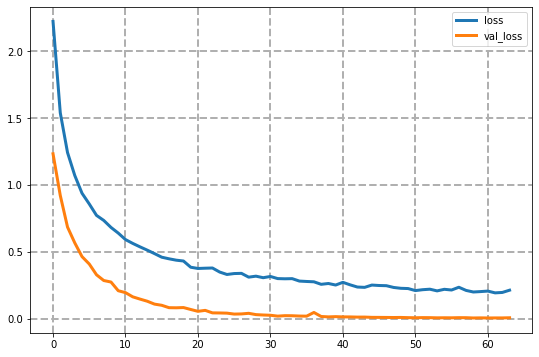

In [ ]:
#plot history and logger
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


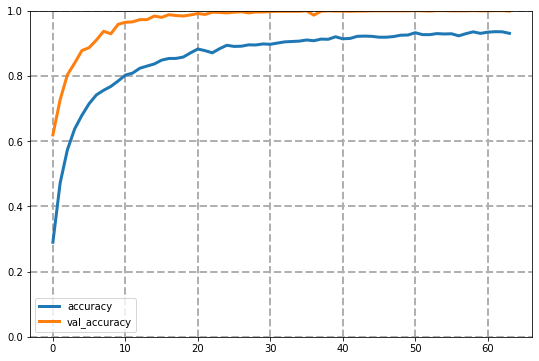

In [ ]:
#plot history and logger
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#model evaluation
train_set_eval = model.evaluate(train_data, verbose = 0)
valid_set_eval = model.evaluate(valid_data, verbose = 0)
test_set_eval = model.evaluate(test_data, verbose = 0)

print(f'Training Set Evaluation:\n\tLoss: {round(train_set_eval[0],4)}\tAccuracy: {100*round(train_set_eval[1],4)}%')
print(f'Validation Set Evaluation:\n\tLoss: {round(valid_set_eval[0],4)}\tAccuracy: {100*round(valid_set_eval[1],4)}%')
print(f'Testing Set Evaluation:\n\tLoss: {round(test_set_eval[0],4)}\tAccuracy: {100*round(test_set_eval[1],4)}%')


Training Set Evaluation:
	Loss: 0.0041	Accuracy: 99.98%
Validation Set Evaluation:
	Loss: 0.004	Accuracy: 100.0%
Testing Set Evaluation:
	Loss: 0.0034	Accuracy: 100.0%


In [ ]:
#make list of images for random prediction
def image_file(dir_path):
    image_list = list()
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            image_list.append(os.path.join(root, file))
    return image_list


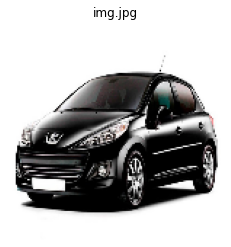

In [ ]:
#draw random image
img = '/content/img.jpg'
image = img
img = keras.preprocessing.image.load_img(img, target_size = (Height, Width),
                                         color_mode = 'rgb')
img = keras.preprocessing.image.img_to_array(img)

img = img/255
plt.axis('off')
plt.imshow(img)
plt.title(image.split('/')[-1])
plt.show()


In [ ]:
#prediction for random image
img = np.expand_dims(img, 0)
pd.DataFrame(model.predict(img), columns = train_data.class_indices).round(5)


,Mazda-2000,Nissan-Zamiad,Peugeot-206,Peugeot-207i,Peugeot-405,Peugeot-Pars,Peykan,Pride-111,Pride-131,Quik,Renault-L90,Samand,Tiba2
0,0.00003,0.0,0.06066,0.93273,0.00002,0.00162,0.00004,0.00012,0.0,0.0014,0.00311,0.00011,0.00017


In [ ]:
#save model
model.save('/content/iranian-automobiles-classification-model.h5')
